In [4]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib ipympl
import pickle
import cv2
import tomli
import glob
import os

In [8]:
base_dir = '/media/fsmresfiles/ASAP/anipose_data/2023-11-01/'

pred_df = pd.read_hdf(os.path.join(base_dir, 'pose-2d/Basler_acA1300-60gm__24254439__20231101_122004999_North.h5'))
filt_df = pd.read_hdf(os.path.join(base_dir, 'pose-2d-filtered/Basler_acA1300-60gm__24254439__20231101_122004999_North.h5'))
proj_df = pd.read_hdf(os.path.join(base_dir, 'pose-2d-proj/Basler_acA1300-60gm__24254439__20231101_122004999_North.h5'))

Text(0.5, 1.0, 'Right Front Paw Y Value')

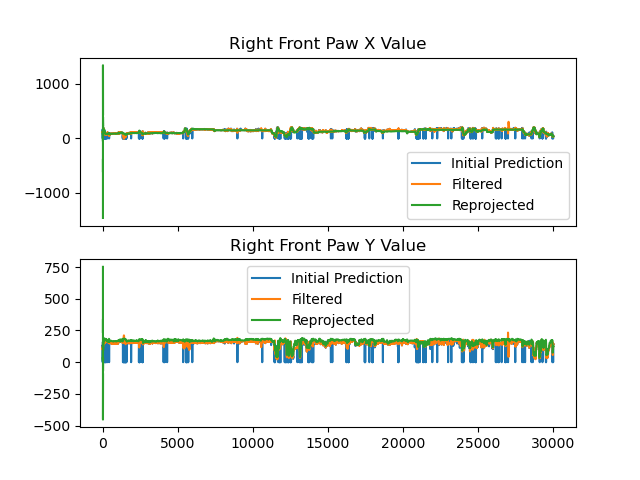

In [10]:
fig,ax = plt.subplots(nrows=2, sharex= True)

bodypart = 'Right Front Paw'

ax[0].plot(pred_df.index,pred_df.loc[:, ('sleap', bodypart, 'x')], label='Initial Prediction')
ax[0].plot(filt_df.index,filt_df.loc[:, ('sleap', bodypart, 'x')], label = 'Filtered')
ax[0].plot(proj_df.index,proj_df.loc[:, ('scorer', bodypart, 'x')], label = 'Reprojected')
ax[0].legend()
ax[0].set_title(f'{bodypart} X Value')

ax[1].plot(pred_df.index,pred_df.loc[:, ('sleap', bodypart, 'y')], label='Initial Prediction')
ax[1].plot(filt_df.index,filt_df.loc[:, ('sleap', bodypart, 'y')], label = 'Filtered')
ax[1].plot(proj_df.index,proj_df.loc[:, ('scorer', bodypart, 'y')], label = 'Reprojected')
ax[1].legend()
ax[1].set_title(f'{bodypart} Y Value')


In [61]:
base_dir = '/media/fsmresfiles/ASAP/anipose_data/2024-05-21/'

# bring in the board detections
with open(os.path.join(base_dir,'calibration/detections.pickle'), 'rb') as fid:
    board_det = pickle.load(fid)

# load the calibration toml to get a list of the cameras etc
with open(os.path.join(base_dir,'calibration/calibration.toml'), 'rb') as fid:
    board_toml = tomli.load(fid)

In [62]:
marked_frame_dir = os.path.join(base_dir, 'calibration/marked_frames/')
if not os.path.exists(marked_frame_dir):
    os.mkdir(marked_frame_dir)

for i_key, (key,value) in enumerate(board_toml.items()):
    if 'cam' not in key:
        continue
    
    calib_fn = glob.glob(f'{base_dir}/calibration/*{value["name"]}*')
    calib_vid = cv2.VideoCapture(calib_fn[0])
    frame_count = calib_vid.get(cv2.CAP_PROP_FRAME_COUNT)

    # print(f'Frames: {frame_count}, length of detect {len(board_det[i_key])}')

    for entry in board_det[i_key]:
        frame_no = entry['framenum'][1]

        calib_vid.set(cv2.CAP_PROP_POS_FRAMES, frame_no)
        ret, frame = calib_vid.read()
        if not ret:
            continue

        for i_point in range(entry['corners'].shape[0]):
            point = entry['corners'][i_point].flatten()
            point_pix = (int(point[0]), int(point[1]))
            frame = cv2.circle(frame, point_pix, 2, (0,0,255), -1)

        # to show the image instead of saving it
        # cv2.imshow('detect',frame)
        # retval = cv2.waitKey()
        # if retval == 27:
        #     break
        
        cv2.imwrite(os.path.join(marked_frame_dir,f'{value["name"]}_{frame_no}.png'), frame)


cv2.destroyAllWindows()
    


Let's try running a unsharp/sharp filter on the thing

In [58]:


unsharp_dir = os.path.join(base_dir, 'calibration/unsharp/')
if not os.path.exists(unsharp_dir):
    os.mkdir(unsharp_dir)

for calib_fn in glob.glob(f'{base_dir}calibration/*.mp4'):
    calib_vid = cv2.VideoCapture(calib_fn)
    frame_count = calib_vid.get(cv2.CAP_PROP_FRAME_COUNT)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    sharp_fn = os.path.splitext(calib_fn)[0]+'_unsharp.mp4'
    shape = (int(calib_vid.get(cv2.CAP_PROP_FRAME_WIDTH)), int(calib_vid.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    sharp_vid = cv2.VideoWriter(sharp_fn, fourcc, calib_vid.get(cv2.CAP_PROP_FPS), shape)
                                
    n_frames = 0
    while True:
        ret, frame = calib_vid.read()
        if not ret:
            break
        n_frames+=1

        gaussian_3 = cv2.GaussianBlur(frame, (0, 0), 2.0)
        unsharp_image = cv2.addWeighted(frame, 10.0, gaussian_3, -9.0, 0)
        sharp_vid.write(unsharp_image)

    print(f'{os.path.split(sharp_fn)[1]}: {n_frames} written')
    sharp_vid.release() 


cv2.destroyAllWindows()

/media/fsmresfiles/ASAP/anipose_data/2024-05-23/calibration: 4248 written
/media/fsmresfiles/ASAP/anipose_data/2024-05-23/calibration: 4248 written
/media/fsmresfiles/ASAP/anipose_data/2024-05-23/calibration: 4248 written
/media/fsmresfiles/ASAP/anipose_data/2024-05-23/calibration: 4248 written
/media/fsmresfiles/ASAP/anipose_data/2024-05-23/calibration: 4248 written


In [37]:
calib_vid.get(cv2.CAP_PROP_FRAME_HEIGHT)

# ret,frame = calib_vid.read()

212.0

In [47]:
calib_vid.set(cv2.CAP_PROP_POS_FRAMES, 0)

True

In [48]:
ret, frame = calib_vid.read()

In [51]:
unsharp_image.dtype

dtype('uint8')